<a href="https://colab.research.google.com/github/keeeehun/RL/blob/main/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Replay Buffer


In [ ]:
class ReplayBuffer:
    """
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py
    with some modifications
    """
    def __init__(self, obs_shape, act_shape, buffer_size):
        buffer_obs_shape = tuple([buffer_size]) + obs_shape
        buffer_act_shape = tuple([buffer_size]) + act_shape
        self.obs_buf = np.zeros(buffer_obs_shape, dtype=np.float32)
        self.act_buf = np.zeros(buffer_act_shape, dtype=np.float32)
        self.ret_buf = np.zeros(buffer_size, dtype=np.float32)
        self.adv_buf = np.zeros(buffer_size, dtype=np.float32)
        self.prob_old_buf = np.zeros(buffer_size, dtype=np.float32)
        self.pointer, self.size, self.buffer_size = 0, 0, buffer_size

    def store(self, obs, act, ret, adv, prob_old):
        self.obs_buf[self.pointer] = obs
        self.act_buf[self.pointer] = act
        self.ret_buf[self.pointer] = ret
        self.adv_buf[self.pointer] = adv
        self.prob_old_buf[self.pointer] = prob_old
        self.pointer = (self.pointer+1) % self.buffer_size
        self.size = min(self.size+1, self.buffer_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     act=self.act_buf[idxs],
                     ret=self.ret_buf[idxs],
                     adv=self.adv_buf[idxs],
                     prob_old=self.prob_old_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

    def __len__(self):
        return self.size

# Policy & Value function

In [ ]:
class CartpolePolicy(nn.Module):
    def __init__(self, obs_dim, n_actions, device):
        super(CartpolePolicy, self).__init__()

        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.device = device

        self.l1 = nn.Linear(obs_dim, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        x = F.softmax(x, dim=-1)

        return x

    def get_action_prob(self, obs):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = obs.to(self.device)
        output = self.forward(obs)
        categorical = Categorical(output)
        action = categorical.sample()
        # logprob = categorical.log_prob(action)
        prob = output.squeeze()[action]

        return action.item(), prob

In [ ]:
class CartpoleCritic(nn.Module):
    def __init__(self, obs_dim, device):
        super(CartpoleCritic, self).__init__()

        self.obs_dim = obs_dim
        self.device = device

        self.l1 = nn.Linear(obs_dim, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)

        return x
    
    def get_value(self, obs):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = obs.to(self.device)
        output = self.forward(obs)

        return output

# Train

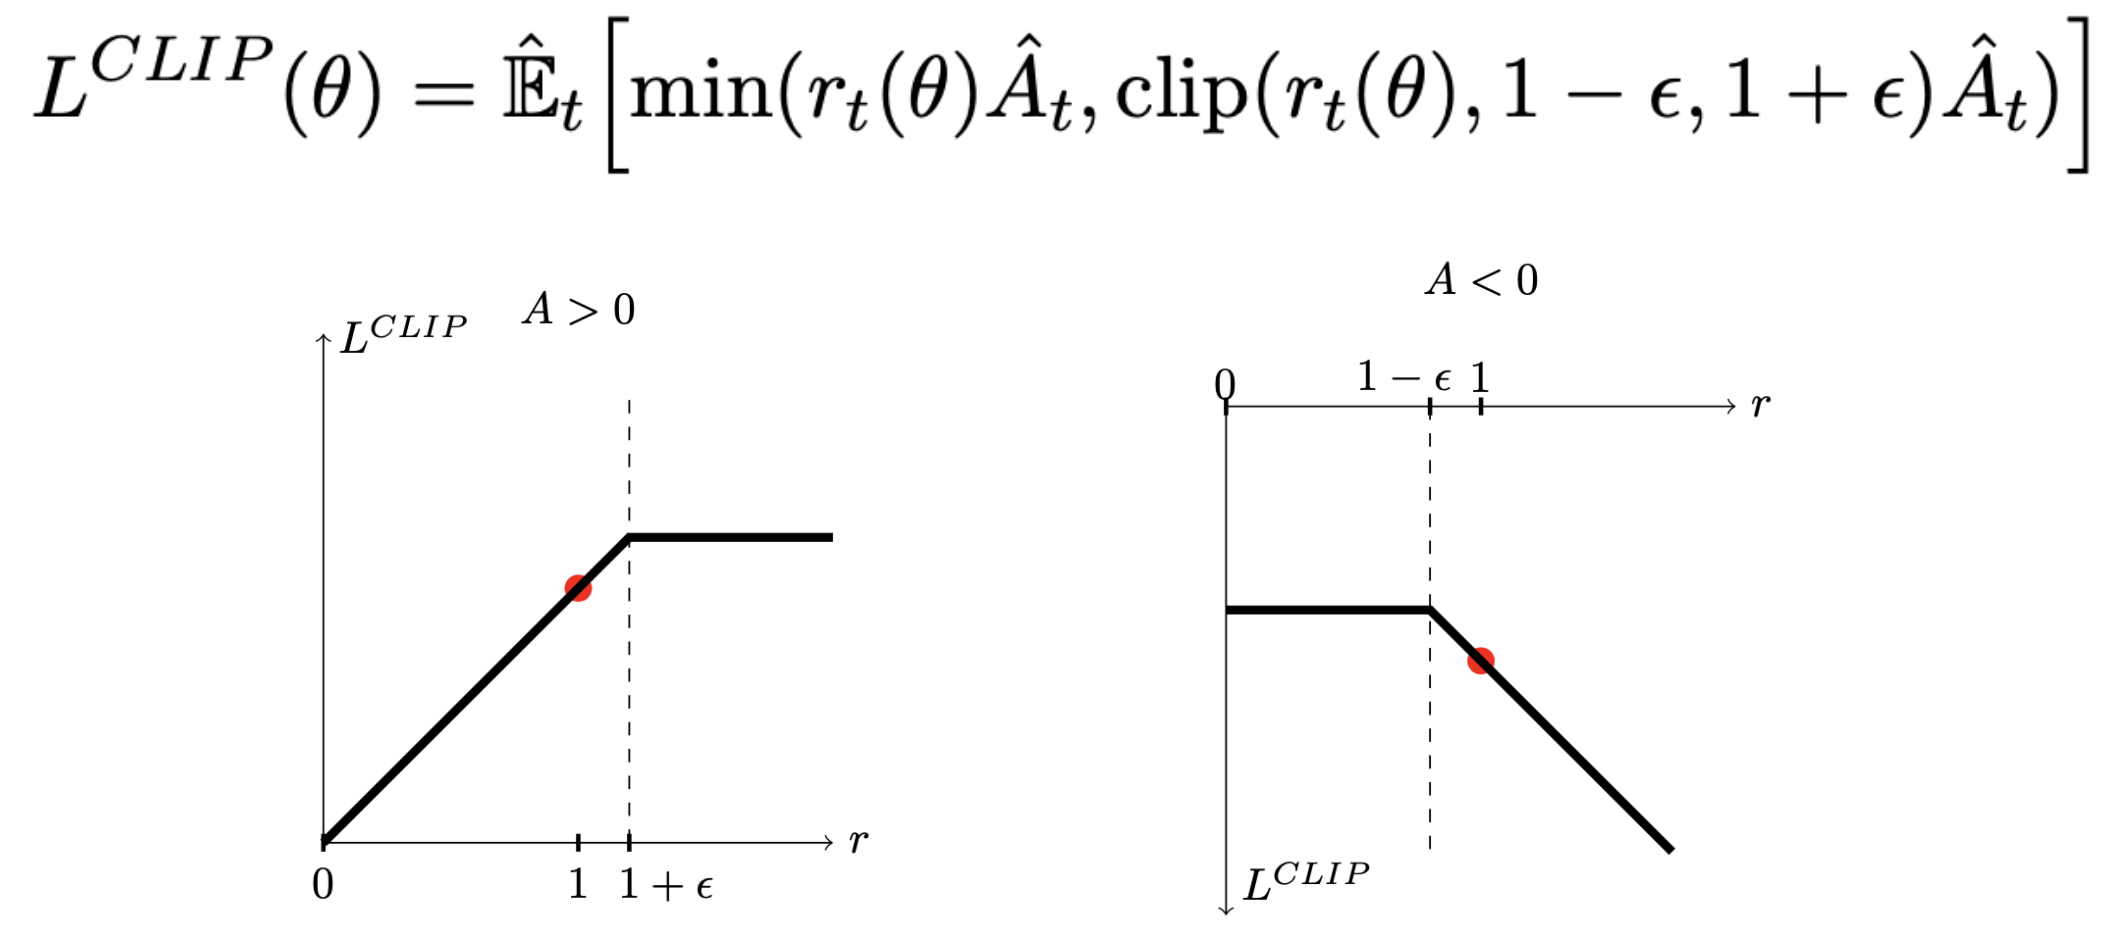

PPO의 구현에 가장 핵심이 되는 부분으로, CLIP surrogate loss를 구현해볼 예정입니다.
위의 식과 그림을 보면 advantage가 양수, 음수일 때 모두 clipping을 해주어서 어느정도 이상 벗어나지 않도록 합니다.

In [ ]:
def train_pi(pi, batch, pi_optimizer, gamma, epsilon, device):
    pi.train()
    
    obs = batch["obs"].to(device) # (batch, 4)
    act = torch.tensor(batch["act"], dtype=torch.int64).to(device) # (batch, 1)
    adv = batch["adv"].to(device) # (batch)
    prob_old = batch["prob_old"].to(device) # (batch)

    pi_output = pi(obs)
    prob = torch.gather(pi_output, 1, act).squeeze(1) # (batch)
    
    ratio = prob / prob_old # (batch)
    l1 = ratio * adv # (batch)
    l2 = torch.clip(input=ratio, min=1-epsilon, max=1+epsilon) * adv # (batch)
    l_clip = -(torch.min(l1, l2)).mean()

    pi_optimizer.zero_grad()
    l_clip.backward()
    pi_optimizer.step()

value function은 return과의 MSE(mean squared error)를 감소시키는 방향으로 학습하게 됩니다.

In [ ]:
def train_v(v, batch, v_optimizer, device):
    v.train()
    
    obs = batch["obs"].to(device) # (batch, 4)
    ret = batch["ret"].to(device) # (batch)

    v_output = v(obs).squeeze(1)
    v_loss = (v_output - ret).pow(2).mean()

    v_optimizer.zero_grad()
    v_loss.backward()
    v_optimizer.step()

# Plot

In [ ]:
def plot(rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    # plt.title('')
    plt.ylabel('reward')
    plt.xlabel('episode')
    plt.plot(rewards)
    plt.show()

# Main

In [ ]:
# Save device (cpu or cuda)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Make env
env = gym.make("CartPole-v0")

# shape
obs_shape = env.observation_space.shape
act_shape = tuple([1]) # int to Tuple
obs_dim = obs_shape[0]
n_actions = env.action_space.n
buffer_size = 1000

# Define NN
pi = CartpolePolicy(obs_dim=obs_dim, n_actions=n_actions, device=device)
v  = CartpoleCritic(obs_dim=obs_dim, device=device)
pi.to(device)
v.to(device)

# Biffer & Optimizer
replay_buffer = ReplayBuffer(obs_shape, act_shape, buffer_size)
pi_optimizer = optim.Adam(pi.parameters())
v_optimizer = optim.Adam(v.parameters())

# training parameters
total_iteration = 200
N = 1 # number of Actors, but here 1. No multiprocessing on this implementation.
batch_size = 32 * N
T = 128
gamma = 0.99
epsilon = 0.2
K = 30 # Num. epochs

# list for saving results
rewards = []

# temperal buffer
obs_list = []
act_list = []
ret_list = []
prob_old_list = []
adv_list = []

코드를 실행하는 메인루프입니다.

- 임시 버퍼를 파이썬의 list 형태로 만들어서 T step동안, 또는 episode가 끝날때까지 저장합니다.
- T step, 또는 episode가 끝나면 그 T step 안에서의 advantage를 계산해준 뒤 메인 버퍼로 옮기게 됩니다.
- policy는 policy gradient로 업데이트 됩니다.
- value function은 return과의 MSE Loss를 감소시키는 방향으로 업데이트 됩니다.

In [ ]:
episode_reward = 0
best_reward = -999999
obs = env.reset()
for i in range(total_iteration):
    # Run policy pi_old in environment for T timesteps
    for t in range(T):
        with torch.no_grad(): # prob_old doesn't require any gradients
            action, prob = pi.get_action_prob(obs)
        next_obs, rew, done, _ = env.step(action)
        episode_reward += rew
        obs_list.append(obs)
        act_list.append(action)
        ret_list.append(rew)
        prob_old_list.append(prob.item())
        obs = next_obs
        
        if done:
            # Save the best model
            if best_reward <= episode_reward:
                best_reward = episode_reward
                torch.save(pi.state_dict(), "pi.pt")
            rewards.append(episode_reward)
            plot(rewards)
            obs_list.append(obs) # For getting V(S_T)
            obs = env.reset()
            episode_reward = 0
            break
    
    # Compute advantage estimates A_1 ... A_T
    for j in range(len(ret_list)-2, -1, -1): # reverse
        ret_list[j] += ret_list[j+1]*gamma
    Vs_T = v.get_value(obs_list[-1]).item()
    for t in range(len(ret_list)):
        Vs_t = v.get_value(obs_list[t]).item()
        adv = -Vs_t + ret_list[t] + gamma**(len(ret_list)-t)*Vs_T
        adv_list.append(adv)
    
    # Save to main buffer & clear out temp buffer
    for j in range(len(ret_list)):
        replay_buffer.store(obs_list[j], act_list[j], ret_list[j], adv_list[j],
                            prob_old_list[j])
    obs_list = []
    act_list = []
    ret_list = []
    prob_old_list = []
    adv_list = []

    # train pi with surrogate L_clip w.r.t. \theta,
    # with K epochs and minibatch size M <= NT
    if len(replay_buffer) > batch_size:
        for _ in range(K):
            # Train pi & v
            sampled_batch = replay_buffer.sample_batch(batch_size=batch_size)
            train_pi(pi, sampled_batch, pi_optimizer, gamma, epsilon, device)
            train_v(v, sampled_batch, v_optimizer, device)

Render

In [ ]:
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gym-notebook-wrapper

In [ ]:
import gnwrapper
import gym

env = gnwrapper.LoopAnimation(gym.make('CartPole-v0'))

obs = env.reset()
for _ in range(500):
    obs, rew, done, _ = env.step(env.action_space.sample()) # Take random action
    env.render()
    if done:
        obs = env.reset()

env.display()

In [ ]:
pi.load_state_dict(torch.load("pi.pt"))

env = gnwrapper.LoopAnimation(gym.make('CartPole-v0'))

obs = env.reset()
for _ in range(500):
    action, _ = pi.get_action_prob(obs)  # Take action from trained model
    env.render()
    obs, rew, done, _ = env.step(action)
    if done:
        obs = env.reset()

env.display()